In [1]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sparse
from ast import literal_eval
import time
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import string

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import defaultdict

# FP Growth

In [2]:
custom_fields = pd.read_csv("tag/acc_tags_set.csv")
custom_fields = custom_fields[custom_fields.org_id == "USC"].copy()
data = []
for i in range(len(custom_fields)):
    tag_list = ast.literal_eval(custom_fields.tags.iloc[i])
    data.append(tag_list)
    

## Number of unique Tags

In [3]:
unique_tags = set()
for k in data:
    for t in k:
        unique_tags.add(t)
print(len(unique_tags))

27


## Number of Unique Accounts

In [4]:
custom_fields=0
len(data)

168481

## Tag Set Frequency

In [5]:

#!/usr/bin/env python3
#encoding:utf-8

from pyspark.sql import SparkSession
from pyspark.mllib.fpm import FPGrowth
 
ss = SparkSession.builder \
        .appName("test_fp") \
        .config("spark.executor.memory", "32G") \
        .config("spark.driver.memory", "32G") \
        .config("spark.python.worker.memory", "32G") \
        .config("spark.default.parallelism", "4") \
        .config("spark.executor.cores", "8") \
        .config("spark.sql.shuffle.partitions", "500") \
        .config("spark.sql.crossJoin.enabled", "true")\
        .config("spark.sql.broadcastTimeout","36000") \
        .enableHiveSupport() \
        .getOrCreate()


rdd = ss.sparkContext.parallelize(data, 2)
print("finish_1")
model = FPGrowth.train(rdd, 0.005, 2)
print(len(data)*0.005)
model.freqItemsets().collect()


finish_1
842.405


[FreqItemset(items=['faNm'], freq=4165),
 FreqItemset(items=['faNm', 'itrans'], freq=1580),
 FreqItemset(items=['faNm', 'itrans', 'advckN'], freq=1492),
 FreqItemset(items=['faNm', 'advckN'], freq=3704),
 FreqItemset(items=['faNm', 'fNoptout'], freq=1343),
 FreqItemset(items=['faNm', 'fNoptout', 'advckN'], freq=1282),
 FreqItemset(items=['faNm', 'fNoptout', 'fbonly'], freq=1042),
 FreqItemset(items=['faNm', 'fNoptout', 'fbonly', 'advckN'], freq=1042),
 FreqItemset(items=['faNm', 'fbonly'], freq=2043),
 FreqItemset(items=['faNm', 'fbonly', 'advckN'], freq=2043),
 FreqItemset(items=['uNps'], freq=66605),
 FreqItemset(items=['uNps', 'uN'], freq=61564),
 FreqItemset(items=['advckN'], freq=26473),
 FreqItemset(items=['fbonly'], freq=6666),
 FreqItemset(items=['fbonly', 'itrans'], freq=2531),
 FreqItemset(items=['fbonly', 'itrans', 'advckN'], freq=2530),
 FreqItemset(items=['fbonly', 'advckN'], freq=6665),
 FreqItemset(items=['advaddN'], freq=68260),
 FreqItemset(items=['itrans'], freq=10905

In [8]:
high_freq_tag = set()
for ts in tag_freq:
    for t in ts.items:
#         print()
        high_freq_tag.add(t)

In [9]:
len(high_freq_tag)

10

In [10]:
freq_count = []
for t in high_freq_tag:
    print(t)
    freq_score = []
    for k in high_freq_tag:
        freq = 0
        temp = []
        for d in data:
            if t in d:
                temp.append(d)
        for d in temp:
            if k in d:
                freq+=1
        freq_score.append(freq)
    freq_count.append(np.array(freq_score))
freq_count = np.array(freq_count)

advckN
midname
fbonly
uNps
advaddN
cm
itrans
faNm
fNoptout
uN


## Heatmap Helper Function

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    
    im = ax.imshow(data, **kwargs)
    
    cbar = add_colorbar(im, ax=ax,**cbar_kw)

    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom",
                      fontsize = 15)


    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(col_labels, fontsize = 13)
    ax.set_yticklabels(row_labels, fontsize = 13)

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)


    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")


    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)

    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.set_title("Number of Accounts that USC Labeled with Both Tags", fontsize = 15)  
    fig.tight_layout()
    
    plt.savefig("tag/heatmap_acc_Num_tagSet_2.png",bbox_inches='tight')
    return im, cbar


## Build Heatmap

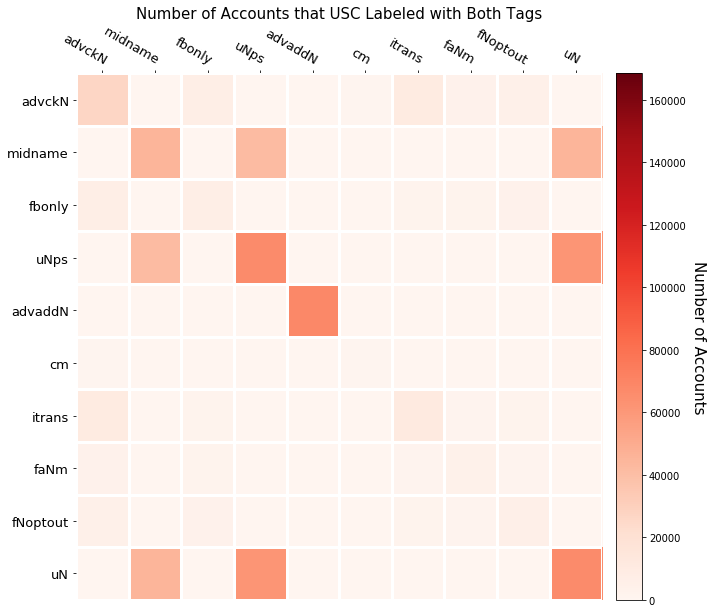

In [16]:
fig, ax = plt.subplots(figsize=(10,10))  
im, _ = heatmap(freq_count, high_freq_tag, high_freq_tag, ax=ax,
                cmap="Reds",cbarlabel="Number of Accounts",vmin = 0,vmax = len(data))